<a href="https://colab.research.google.com/github/leomaestri/DeepLearning_VAE-GANs_Project/blob/master/VAEGAN_chairs_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Library Imports

In [1]:
# Link de origen de datos: https://vcc.tech/research/2018/G2L
# Loading libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits import mplot3d

import glob
import sys
import os

import torch
import torchvision
import torch.utils.data
import torch.nn as nn
import torch.functional as F
from torchvision import datasets, transforms

from skimage import io, transform
import scipy.io as sio

import random
from IPython.display import display, clear_output

In [2]:
torch.autograd.set_detect_anomaly(True)

In [3]:
## Funciones para alterar en el codigo que repite mucha logica
def aTensor(chair):
    return torch.Tensor(chair)

## Data Loading

In [4]:
# Permito el acceso de colab a mi drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# Copio de mi drive a la notebook el dataset de sillas
!cp -r "drive/My Drive/data/chair" /content/chair

# Creo la carpeta modelos (hacer un if por si ya esta creada)
!mkdir modelos

In [6]:
def load_mat(matFile, cube_len):
    data = sio.loadmat(matFile)
    volume_size = (cube_len, cube_len, cube_len)
    array = np.ndarray(volume_size, np.int32)
    array = data['instance']
    return array

In [7]:
# Dataset a para cargarle las sillas
class DirChairDataset(torch.utils.data.Dataset):
    """
    Dataset de sillas 3D desde directorio
    """
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        assert os.path.exists(root_dir)
        self.root_dir = root_dir
        self.archivos = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.archivos)

    def __getitem__(self, idx):
        matriz = load_mat(os.path.join(self.root_dir, self.archivos[idx]), 32)
        sample = matriz[np.newaxis, ...] # Le agrego un canal
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def load_mat(matFile, cube_len):
        data = sio.loadmat(matFile)
        volume_size = (cube_len, cube_len, cube_len)
        array = np.ndarray(volume_size, np.int32)
        array = data['instance'] # No se pueden combinar estas 2 celdas, o 3 con el return
        return array


In [8]:
data_path = 'chair/train/'

In [9]:
chair_files = os.listdir(data_path)
prueba = DirChairDataset.load_mat(data_path + chair_files[0], 64)

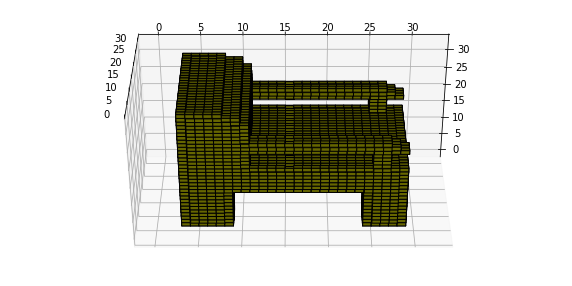

In [10]:
# Pruebo levantando una matriz como ejemplo.
# Las partes tienen asignados distintos numeros, del 1 al 4

fig = plt.figure(figsize=(10, 5))
axes = fig.gca(projection='3d')
axes.voxels(prueba, facecolors='y', edgecolors='k')
axes.view_init(-55, 0)
plt.draw()
plt.pause(.001)

plt.show()

In [11]:
# Semilla
seed = 1234

# Intersection over union (IoU) 
# Es una metrica que me dice que tan bien se detecto un objeto. Lleva ese nombre
# porque se refiere a la 'intersección' entre el area detectada real y la prediccion area detectada,
# 'over' de 'sobre' como una fraccion y 'union' entre el area detectada real y 
# la prediccion area detectada. Me dice cuanto de el area real se detecto.

def iou(pred, target):
  intersection = torch.Tensor(pred * target).long().sum()
  union = torch.Tensor(pred + target).long().sum() - intersection
  # intersection = (pred_inds[target_inds]).long().sum().data.cpu()[0]  # Cast to long to prevent overflows
  # union = pred_inds.long().sum().data.cpu()[0] + target_inds.long().sum().data.cpu()[0] - intersection

  iou = None
  if union == 0:
    iou = 'nan'  # If there is no ground truth, do not include in evaluation
  else:
    iou = float(intersection) / float(max(union, 1))

  return iou

# **Red Neuronal ResNet VAE**

### Convolutions

In [12]:
def conv3x3x3(in_planes, out_planes, stride=1, groups=1, padding=0):
    """3x3 convolution with padding"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, groups=groups, bias=False)

def conv4x4x4(in_planes, out_planes, stride=1, groups=1, padding=0):
    """4x4 convolution with padding"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=4, stride=stride,
                     padding=padding, groups=groups, bias=False)
    
def conv1x1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=stride,
                     bias=False)

## Deconvolutions

In [13]:
# Las Traspuestas son las deconvoluciones
def t_conv3x3x3(in_planes, out_planes, stride=1, groups=1, padding=0):
    """3x3 convolution with padding"""
    return nn.ConvTranspose3d(in_planes, out_planes, kernel_size=3,
                              stride=stride, padding=padding, groups=groups,
                              bias=False)

def t_conv4x4x4(in_planes, out_planes, stride=1, groups=1, padding=0):
    """4x4 convolution with padding"""
    return nn.ConvTranspose3d(in_planes, out_planes, kernel_size=4,
                              stride=stride, padding=padding, groups=groups,
                              bias=False)
    
def t_conv2x2x2(in_planes, out_planes, stride=1, groups=1, padding=0):
    """2x2 convolution with padding"""
    return nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2 ,
                              stride=stride, padding=padding, groups=groups,
                              bias=False)
    
def t_conv1x1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.ConvTranspose3d(in_planes, out_planes, kernel_size=1,
                              stride=stride, bias=False)   
        
def t_conv2x2x2(in_planes, out_planes, stride=1):
    """2x2 convolution"""
    return nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2,
                              stride=stride, bias=False)

## Convolution Blocks

In [14]:
# Bloque de convolucion 1
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3x3(inplanes, planes, stride=stride, padding=1)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes, stride=1, padding=1)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample     #???
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Bloque de convolucion 2
class BasicBlock2(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, norm_layer=None):
        super(BasicBlock2, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv4x4x4(inplanes, planes, stride=stride, padding=1)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        # La siguiente convolución no modifica la dimensionalidad de lo que sale
        # de la conv1.
        self.conv2 = conv3x3x3(planes, planes, stride=1, padding=1)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Bloque de deconvolucion 1
class BasicBlock_dec(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, upsample=None, groups=1,
                 base_width=64, norm_layer=None, padding=1):
        super(BasicBlock_dec, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        self.conv1 = t_conv3x3x3(inplanes, planes, stride=stride,
                                 padding=padding)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = t_conv3x3x3(planes, planes, stride=1, padding=padding)
        self.bn2 = norm_layer(planes)
        self.upsample = upsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        out = self.relu(out)

        return out

# Bloque de deconvolucion 2
class BasicBlock_dec2(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, upsample=None, groups=1,
                 base_width=64, norm_layer=None, padding=1):
        super(BasicBlock_dec2, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        self.conv1 = t_conv4x4x4(inplanes, planes, stride=stride,
                                 padding=padding)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = t_conv3x3x3(planes, planes, stride=1, padding=padding)
        self.bn2 = norm_layer(planes)
        self.upsample = upsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        out = self.relu(out)

        return out

## Bottleneck

In [15]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

## Residual Net

In [16]:
# Encoder

class ResNet2(nn.Module):
    def __init__(self, block, layers, z_dim=100, zero_init_residual=False,
                 groups=1, width_per_group=64,
                 norm_layer=None):
        super(ResNet2, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv3d(1, self.inplanes, kernel_size=4, stride=4)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # Elimino el maxpool respecto a "ResNet"
        self.layer1 = self._make_layer(block, 128, layers[0], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[2], stride=2)
        self.fc1 = nn.Linear(512, z_dim)
        self.fc2 = nn.Linear(512, z_dim)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                conv1x1x1(self.inplanes, planes, stride=stride),
                norm_layer(planes)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, norm_layer))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def reparameterize(self, mu, log_var):
        """ Reparameterizing trick done by the VAE """
        std = torch.exp(log_var*0.5)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = torch.flatten(x, 1)
        mu = self.fc1(x)
        logvar = self.fc2(x)
        z = self.reparameterize(mu, logvar)

        return mu, logvar, z


# Decoder

class ResNet_dec2(nn.Module):
    def __init__(self, block, layers, z_dim=100, zero_init_residual=False,
                 groups=1, width_per_group=64,
                 norm_layer=None):
        super(ResNet_dec2, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        self._norm_layer = norm_layer

        self.inplanes = 512
        self.groups = groups
        self.base_width = width_per_group
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 256, layers[0], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.conv1 = nn.ConvTranspose3d(64, 1, kernel_size=4, stride=4)
        # Elimino el maxpool
        self.fc = nn.Linear(z_dim, 512)
        self.sigm = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm3d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        upsample = None
        if stride != 1 or self.inplanes != planes:
            upsample = nn.Sequential(
                t_conv2x2x2(self.inplanes, planes,
                            stride=stride),
                norm_layer(planes)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, upsample,
                            self.groups, self.base_width, norm_layer))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock_dec(self.inplanes, planes,
                                         groups=self.groups,
                                         base_width=self.base_width,
                                         norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.fc(x))
        x = x.view(-1, 512, 1, 1, 1)

        x = self.bn1(x) # Entiendo que no debería servir, porque viene 1x1x1
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.conv1(x)
        return self.sigm(x)

## Residual Variational Auto Encoder 

In [17]:
class ResNetVAE2(nn.Module):
    def __init__(self, block, layers, z_dim=100, zero_init_residual=False,
                 groups=1, width_per_group=64,
                 norm_layer=None):
        super(ResNetVAE2, self).__init__()
        self.encoder = ResNet2(block, layers, z_dim=z_dim) #, **kwargs)
        self.decoder = ResNet_dec2(BasicBlock_dec2, layers, z_dim=z_dim*4) #, **kwargs) # modificado para tener en cuenta las 4 partes del VAE
    
    def forward(self, x):
        mu, logvar, z = self.encoder(x)
        x_reconst = self.decoder(z)
        # x_reconst = self.decoder(mu) # Modificado para hacerlo como autoencoder.
        return x_reconst , mu, logvar, z

def _resnet_VAE2(arch, block, z_dim, layers, progress, **kwargs):
    model = ResNetVAE2(block, layers, z_dim=z_dim)
    return model  

def resnet18VAE2(z_dim=100, pretrained=False, progress=True, **kwargs):
    return _resnet_VAE2('resnet18', BasicBlock2, z_dim, [2, 2, 2, 2],
                        progress=progress)


# GANs

### Discriminator

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv3d(in_channels = 1, out_channels = 64, kernel_size = 4, stride = 2, padding = 1),#, kernel_initializer='he_uniform'),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.2), #0.3 #0.4
            
            nn.Conv3d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1),#, kernel_initializer='he_uniform'),,
            nn.BatchNorm3d(128),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.2), #0.3 #0.4
            
            nn.Conv3d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1),#, kernel_initializer='he_uniform'),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(0.5), #0.4 #0.3
            
            nn.Conv3d(in_channels = 256, out_channels = 1, kernel_size = 4, stride = 1),# , kernel_initializer='he_uniform'),
            nn.Sigmoid()
            # Como genero los logit scores? serian 2 en este caso? (real y falso)
            #nn.LeakyReLU(negative_slope=0.2),
            #nn.Softmax(dim=-1)
        )
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                
                #m.weight = nn.init.kaiming_normal_(m.weight, mode='fan_out')
                #if m.bias is not None: m.bias.data.zero_()
                
                #nn.init.kaiming_uniform(m.weight.data, mode='fan_out')
                
                #nn.init.kaiming_normal_(m.weight, mode='fan_out') 
                #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
                nn.init.xavier_normal(m.weight, gain=np.sqrt(2)) 
                #nn.init.xavier_normal(m.weight) # NO PROBADO
                #nn.init.xavier_uniform(m.weight) # NO PROBADO
        self.cuda()

    def forward(self, x):
        if (len(x.shape) < 5):
            x = x.unsqueeze(dim = 1) # add dimension for channels
            
        return self.layers(x).squeeze()

    def clip_weights(self, value):
        for parameter in self.parameters():
            parameter.data.clamp_(-value, value)

#### Dis Training

In [ ]:
data_path = 'chair/train/'

batch_size = 4
learning_rate = 1e-3
learning_rate_D = 1e-3
num_epochs = 5
use_dropout = True
z_dim = 25

reduction ='mean'   # modifica el parametro "reduction" de las funciones de pérdida
mult_parts = 1      # modificador de la funcion de perdida de las partes.
mult_adj = 0        # multiplicador de la parte de adyacencia de la loss total.
#mult_l1 = 1        # se estaba pasando por parametro pero no lo uso en ningun lado
mult_kldiv = 1      # multiplicador de la parte KL-Div de la loss total.
mult_bce = 1        # multiplicador de la parte BCE de la loss total.

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

num_run = 35
z_dim = 25
num_epochs = 400
batch_size=4
#bz = 32
mult_kldiv=1e-5
learning_rate=1e-3
learning_rate_D = 6e-4 
mult_parts=0.1

criterion = nn.BCELoss(reduction=reduction)
generador = resnet18VAE2(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

# Cargo los datos de train
train_chair_data = DirChairDataset(data_path, transform=trf_composed)  
train_chair_data_loader = torch.utils.data.DataLoader(dataset=train_chair_data,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    drop_last=True)
for i, x in enumerate(train_chair_data_loader):
  x_real = x.to(device)            
  output = discriminator(x_real)
  print(f"{i}_{output}")

In [36]:
#from tqdm import tqdm # Para mostrar las barras de progreso

# Variables
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-3    #Default
learning_rate_D = 1e-3  #Default
num_epochs = 30
batch_size = 4

trf_composed = transforms.Compose([aTensor])  
data_path = 'chair/train/'

dataset = DirChairDataset(data_path, transform=trf_composed)  
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size,
                                          shuffle=True, drop_last=True)

y_real_default = torch.ones(batch_size, requires_grad=False).to(device)
y_falso_default = torch.zeros(batch_size, requires_grad=False).to(device)

discriminator = Discriminator().to(device)

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_D, betas=(0.5, 0.999))

def Dis_train(data):

    # train discriminator on real samples
    x_real = data.to(device)
    y_real = torch.ones(batch_size, requires_grad=False).to(device)
    y_falso = torch.zeros(batch_size, requires_grad=False).to(device) 

    optimizerD.zero_grad()
    discriminator_output = discriminator(x_real)
    D_real_loss = criterion(discriminator_output, y_real)


    # train discriminator on fake samples                
    x_falso = G_generate(data, generador, device)
    y_falso = y_falso.to(device)

    discriminator_output = discriminator(x_falso)
    D_fake_loss = criterion(discriminator_output, y_falso)

    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    optimizerD.step()

    return  D_loss

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


### Generator

In [41]:
def G_generate(x, model, device):

    part1, part2, part3, part4 = [(x == (i + 1)).float().to(device) for i in range(4)]
    
    _,_,part1_z = model.encoder(part1)
    _,_,part2_z = model.encoder(part2)
    _,_,part3_z = model.encoder(part3)
    _,_,part4_z = model.encoder(part4)
    z_total = torch.cat([part1_z, part2_z, part3_z, part4_z], dim=1)

    y_reconst = model.decoder(z_total)

    return y_reconst

In [42]:
def Reconstruccion(model, device, part_z, bachsize, largo):
    placeholder = torch.zeros([bachsize, largo])
    placeholder[:, 0:25] = part_z
    part_z = placeholder.to(device)
    return model.decoder(part_z)

#### Gen Training

In [43]:
def G_train(x, device, model, optimizer):
    # Forward pass
    # Separa las partes (tienen 1,2,3,4 dentro del dataset, 0 quiere decir vacio)
    part1, part2, part3, part4 = [(x == (i + 1)).float().to(device) for i in range(4)]
    
    ## ENCODER [me da mu, logvar, z]
    part1_mu, part1_log_var, part1_z = model.encoder(part1)
    part2_mu, part2_log_var, part2_z = model.encoder(part2)
    part3_mu, part3_log_var, part3_z = model.encoder(part3)
    part4_mu, part4_log_var, part4_z = model.encoder(part4)
    # mu, log_var, z_total = model.encoder(y)

    # Silla completa sin discriminar partes
    mask_chair = x > 0;    x[mask_chair] = 1;    x[~mask_chair] = 0;    y = x.to(device)

    # Concatenado de las partes
    z_total = torch.cat([part1_z, part2_z, part3_z, part4_z], dim=1)
    mu_total = torch.cat([part1_mu, part2_mu, part3_mu, part4_mu], dim=1)
    log_var_total = torch.cat([part1_log_var, part2_log_var, part3_log_var, part4_log_var], dim=1)
            
    # Hasta acá se arma el código concatenado, ahora armo la reconstrucción con los latent codes por partes paddeados
    largo = z_total.shape[1]
    
    optimizer.zero_grad() # Nose si va aca o justo antes del backward como estaba puesto

    y_reconst = model.decoder(z_total)

    y_si_fuera_real = torch.ones(batch_size, requires_grad=False).to(device)
    discriminator_output = discriminator(y_reconst)
    D_real_loss = criterion(discriminator_output, y_si_fuera_real) # AGREGAR LA LOSS DE DISCRIMINADOR A LA DEL GENERADOR VAE LOSS

    
    ##### Calculo las losses #####
    
    # De la silla completa
    reconst_loss = criterion(y_reconst, y)
    
    # De cada parte de la silla
    reconst_loss1 = criterion( Reconstruccion(model, device, part1_z, batch_size, largo), part1 )
    reconst_loss2 = criterion( Reconstruccion(model, device, part2_z, batch_size, largo), part2 )
    reconst_loss3 = criterion( Reconstruccion(model, device, part3_z, batch_size, largo), part3 )
    reconst_loss4 = criterion( Reconstruccion(model, device, part4_z, batch_size, largo), part4 )
    
    #L1 Loss
    criterionL1 = nn.SmoothL1Loss(reduction=reduction)
    reconst_L1 = criterionL1(y_reconst, y)
    
    # KL Divergence Loss
    kl_div = -0.5 * torch.sum(1 + log_var_total - mu_total.pow(2) - log_var_total.exp(), dim=-1)
    kl_div = torch.sum(kl_div)

    # Loss Total para la optimizacion
    loss = mult_bce * reconst_loss + mult_parts * (reconst_loss1 + reconst_loss2 + reconst_loss3 + reconst_loss4) + mult_kldiv * kl_div + 0.1 * reconst_L1 + D_real_loss * 0.4
           # + mult_adj * adj)
    # 0.1 es el valor de lambda1 que le dan a la reconstrucción por partes del código overcomplete que usan en Yin et al. 2019 (LOGAN)
    

    #optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return  y_reconst, loss, kl_div, reconst_L1, reconst_loss, y

# Loss Functions

## Calculation

In [44]:
# Intersection over union (IoU) 
# Es una metrica que me dice que tan bien se detecto un objeto. Lleva ese nombre
# porque se refiere a la 'intersección' entre el area detectada real y la prediccion area detectada,
# 'over' de 'sobre' como una fraccion y 'union' entre el area detectada real y 
# la prediccion area detectada. Me dice cuanto de el area real se detecto.

def iou(pred, target):
  intersection = torch.Tensor(pred * target).long().sum()
  union = torch.Tensor(pred + target).long().sum() - intersection
  # intersection = (pred_inds[target_inds]).long().sum().data.cpu()[0]  # Cast to long to prevent overflows
  # union = pred_inds.long().sum().data.cpu()[0] + target_inds.long().sum().data.cpu()[0] - intersection

  iou = None
  if union == 0:
    iou = 'nan'  # If there is no ground truth, do not include in evaluation
  else:
    iou = float(intersection) / float(max(union, 1))
  return iou
    

In [45]:
def VAE_loss(y, part1, part2, part3, part4, y_reconst, y1_reconst, y2_reconst, y3_reconst, y4_reconst, log_var_total, mu_total):

    criterionL1 = nn.SmoothL1Loss(reduction=reduction)

    # Estos 4 los puedo dejar afuera del VAE_Loss, directo de reconstruccion
    reconst_loss = criterion(y_reconst, y)
    reconst_loss1 = criterion(y1_reconst, part1)
    reconst_loss2 = criterion(y2_reconst, part2)
    reconst_loss3 = criterion(y3_reconst, part3)
    reconst_loss4 = criterion(y4_reconst, part4)

    reconst_L1 = criterionL1(y_reconst, y)
            
    kl_div = -0.5 * torch.sum(1 + log_var_total - mu_total.pow(2) - log_var_total.exp(), dim=-1)
    kl_div = torch.sum(kl_div)

    # Backprop and optimize
    # 0.1 es el valor de lambda1 que le dan a la reconstrucción por partes del código overcomplete que usan en Yin et al. 2019 (LOGAN)
    loss = mult_bce * reconst_loss + mult_parts * (reconst_loss1 + reconst_loss2 + reconst_loss3 + reconst_loss4) + mult_kldiv * kl_div + 0.1 * reconst_L1
           # + mult_adj * adj)

    return loss, kl_div, reconst_L1, reconst_loss

## Ploting

In [46]:
def Ploteo_Losses(num_epochs, total_sum, bce_sum, l1_sum, kl_div_sum, iou_sum, total_mean, bce_mean, l1_mean, kl_div_mean, iou_mean):

    epochl = np.array([i + 1 for i in range(num_epochs)])
    fig = plt.figure(figsize=(20, 10))
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10 = [fig.add_subplot(2, 5, i+1) for i in range(10)]
    
     
    # Ploteo las sumatorias
    # titulos = ['Total Loss (sum)', 'BCE Loss (sum)', 'L1 Loss (sum)', 'KL Divergence (sum)', 'IoU Loss (sum)',
    #            'Total Loss (mean)', 'BCE Loss (mean)', 'L1 Loss (mean)', 'KL Divergence (mean)', 'IoU Loss (mean)']
    # datos = [total_sum, bce_sum, l1_sum, kl_div_sum, iou_sum, total_mean, bce_mean, l1_mean, kl_div_mean, iou_mean]

    # ejes = [fig.add_subplot(2, 5, i+1) for i in range(10)]
    # for i, grafico in enumerate(datos):
    #     ejes[i].cla()
    #     ejes[i].set_xlim(0, num_epochs)
    #     ejes[i].set_title(titulos[i])
    #     ejes[i].plot(epochl, datos)


    ax1.cla(); ax1.set_xlim(0, num_epochs); ax1.set_title('Total Loss (sum)'); ax1.plot(epochl, total_sum)
    ax2.cla(); ax2.set_xlim(0, num_epochs); ax2.set_title('BCE Loss (sum)'); ax2.plot(epochl, bce_sum, 'r-')
    ax3.cla(); ax3.set_xlim(0, num_epochs); ax3.set_title('L1 Loss (sum)'); ax3.plot(epochl, l1_sum, 'g-')
    ax4.cla(); ax4.set_xlim(0, num_epochs); ax4.set_title('KL Divergence (sum)'); ax4.plot(epochl, kl_div_sum, 'k-')
    ax5.cla(); ax5.set_xlim(0, num_epochs); ax5.set_title('IoU Loss (sum)'); ax5.plot(epochl, iou_sum)

    # Ploteo las medias
    ax6.cla(); ax6.set_xlim(0, num_epochs); ax6.set_title('Total Loss (mean)'); ax6.plot(epochl, total_mean)
    ax7.cla(); ax7.set_xlim(0, num_epochs); ax7.set_title('BCE Loss (mean)'); ax7.plot(epochl, bce_mean, 'r-')
    ax8.cla(); ax8.set_xlim(0, num_epochs); ax8.set_title('L1 Loss (mean)'); ax8.plot(epochl, l1_mean, 'g-')
    ax9.cla(); ax9.set_xlim(0, num_epochs); ax9.set_title('KL Divergence (mean)'); ax9.plot(epochl, kl_div_mean, 'k-')
    ax10.cla(); ax10.set_xlim(0, num_epochs); ax10.set_title('IoU Loss (mean)'); ax10.plot(epochl, iou_mean)

# Training Functions

In [47]:
# Variables del modelo

batch_size = 4
learning_rate = 1e-3
learning_rate_D = 1e-3
num_epochs = 5
use_dropout = True
z_dim = 25

reduction ='mean'   # modifica el parametro "reduction" de las funciones de pérdida
mult_parts = 1      # modificador de la funcion de perdida de las partes.
mult_adj = 0        # multiplicador de la parte de adyacencia de la loss total.
#mult_l1 = 1        # se estaba pasando por parametro pero no lo uso en ningun lado
mult_kldiv = 1      # multiplicador de la parte KL-Div de la loss total.
mult_bce = 1        # multiplicador de la parte BCE de la loss total.


criterion = nn.BCELoss(reduction=reduction)
generador = resnet18VAE2(z_dim=z_dim).to(device)

def binaria(y):
    y = y.to('cpu').numpy()
    mask = y > 0.5
    y[mask] = 1
    y[~mask] = 0
    return y

In [48]:
def correr_VAE(generador, discriminator, data_name, num_run):

    # Variables
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trf_composed = transforms.Compose([aTensor])
    data_path = 'chair/train/'
    
    # Cargo los datos de train
    train_chair_data = DirChairDataset(data_path, transform=trf_composed)  
    train_chair_data_loader = torch.utils.data.DataLoader(dataset=train_chair_data,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        drop_last=True)
    #print(generador)
    modelo_total_params = sum(p.numel() for p in generador.parameters())
    print("Total number of parameters in Generator", modelo_total_params)

    #print(discriminator)
    modelo_total_params = sum(p.numel() for p in discriminator.parameters())
    print("Total number of parameters in Discriminator", modelo_total_params)

    optimizerG = torch.optim.Adam(generador.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizerD = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_D, betas=(0.5, 0.999))

    ## Variables para el calculo de loss, las inicializo como arrays de nulos
    l1_sum, bce_sum, kl_div_sum, total_sum, iou_sum, l1_mean, bce_mean, kl_div_mean, total_mean, iou_mean = [np.full(num_epochs, np.nan) for i in range(10)]

    # Start training
    generador.train()
    discriminator.train()

    D_losses_bce = np.full(num_epochs, np.nan)
    G_losses_bce = np.full(num_epochs, np.nan)

    for epoch in range(num_epochs):
        
        kl_div_losses = bce_losses = l1_losses = total_losses = iou_losses = cantidad_para_mean_loss = 0
        D_loss_bce = G_loss_bce = 0

        for i, x in enumerate(train_chair_data_loader):
            
            # Loss discriminador
            D_Loss = Dis_train(x)
            #D_losses_bce.append(D_Loss.item())
            #D_losses_bce[i] = D_Loss
            D_loss_bce += D_Loss # Ploteo por Epoca en vez de iteración

            y_reconst, loss, kl_div, reconst_L1, reconst_loss, y = G_train(x, device, generador, optimizerG)
            
            
            with torch.no_grad():

                # IoU loss
                y = binaria(y)
                y_reconst = binaria(y_reconst)

                #y = y.to('cpu').numpy(); mask = y > 0.5; y[mask] = 1; y[~mask] = 0
                #y_reconst = y_reconst.to('cpu').numpy(); mask = y_reconst > 0.5; y_reconst[mask] = 1; y_reconst[~mask] = 0

                iou_salida = iou(y_reconst, y)

             ## Voy generando las sumatorias en cada iteracion
            #cantidad_para_mean_loss += 1 # Siempre es 25 asi que asumo que es el z_dim
            kl_div_losses +=  kl_div
            l1_losses += reconst_L1
            bce_losses += reconst_loss
            total_losses += loss
            iou_losses += iou_salida

            # BCELoss del generador para plotear en paralelo con el discriminador
            #G_losses_bce.append(reconst_loss.item())
            #G_losses_bce[i] = reconst_loss
            G_loss_bce += reconst_loss # Ploteo por Epoca en vez de iteración

        # Si cantidad_para_mean_loss es siempre igual en todas las epocas fijarlo con un numero (len (datos))
        # print (f"cantidad_para_mean_loss = {cantidad_para_mean_loss}")

        # Guardo la sumatoria de la epoch    
        l1_sum[epoch] = l1_losses;              bce_sum[epoch] = bce_losses
        kl_div_sum[epoch] = kl_div_losses;      total_sum[epoch] = total_losses
        iou_sum[epoch] = iou_losses
        
        D_losses_bce[epoch] = D_loss_bce
        G_losses_bce[epoch] = G_loss_bce

        # Guardo las medias de la epoch
        l1_mean[epoch] = l1_losses / 25
        bce_mean[epoch] = bce_losses / 25
        kl_div_mean[epoch] = kl_div_losses / 25
        total_mean[epoch] = total_losses / 25
        iou_mean[epoch] = iou_losses / 25
        media_Dis = D_loss_bce / 25

        meanLosses_epoca = f"Epoch[{epoch+1}/{num_epochs}], Reconst Loss: {round(bce_mean[epoch].item(), 2)}, KL Div: {round(kl_div_mean[epoch].item(), 2)}, L1 Loss: {round(l1_mean[epoch].item(), 2)}, Total Loss: {round(total_mean[epoch].item(), 2)}, BCE_Dis {round(media_Dis.item(), 2)}"
        print(meanLosses_epoca)
      
    torch.save(generador, 'modelos/part_chair_vaegan_G_run_' + str(num_run) + '_' +
                str(device) + '.pth')
    
    torch.save(discriminator, 'modelos/part_chair_vaegan_D_run_' + str(num_run) + '_' +
                str(device) + '.pth')
    
    # Ploteo de losses
    Ploteo_Losses(num_epochs, total_sum, bce_sum, l1_sum, kl_div_sum, iou_sum, total_mean, bce_mean, l1_mean, kl_div_mean, iou_mean)
    # Ploteo_Losses(num_epochs, total_sum, bce_sum, l1_sum, kl_div_sum, iou_sum, total_mean, bce_mean, l1_mean, kl_div_mean, iou_mean) # Cuando solo ploteo la Sumatoria 

    #Ploteo la loss del discriminador
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator BCELoss During Training")
    plt.plot(G_losses_bce, label="G")
    plt.plot(D_losses_bce, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    #Por si se alejan demaciado las curvas las ploteo solas
    plt.figure(figsize=(10,5))
    plt.title("Generator BCELoss During Training")
    plt.plot(G_losses_bce, label="G")
    #plt.plot(D_losses_bce, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.title("Discriminator BCELoss During Training")
    #plt.plot(G_losses_bce, label="G")
    plt.plot(D_losses_bce, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Model Training

In [62]:
# Primero probado con Kaiming He initialization
# https://arxiv.org/pdf/1502.01852.pdf

# Semilla
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

num_run = 35
z_dim = 25
num_epochs = 400
batch_size=32
#bz = 32
mult_kldiv=1e-5
learning_rate=1e-3
learning_rate_D = 6e-4 
mult_parts=0.1

generador = resnet18VAE2(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

#correr_VAE(generador, discriminator, 'chairs_2', num_run)

# Sigmoid con inicializador nn.init.xavier_normal(m.weight, gain=np.sqrt(2))
# Dropout en el discriminador
# Le baje la relevancia del loss del discriminador para el generador a 0.4
# Usando Batchnorm 3d en el discriminador (las primeras 3 capas)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


In [63]:
# Guardar un modelo en el drive

#!cp modelos/part_chair_vaegan_G_run_28_cuda.pth "drive/My Drive/modelos/" 
#!cp modelos/part_chair_vaegan_D_run_28_cuda.pth "drive/My Drive/modelos/" 

# Model Outputs

## Ploting

In [64]:
def normalizar(y, valorComparacion):
   mask = y > valorComparacion
   y[mask] = 1
   y[~mask] = 0
   return y

def girar_grafico_3D_frente(grafico):
  grafico.view_init(-55, 35) # eje x, eje z   (-55, 35)frente
  plt.draw()
  return grafico

def mostrar_voxel_normalizado_frente(*args):
  for x in args:
    fig = plt.figure(figsize=(20, 10))
    axes = fig.gca(projection='3d')
    axes.voxels(x, facecolors='y', edgecolors='k')
    axes = girar_grafico_3D_frente(axes)
    plt.show()

def mostrar_voxel_normalizado_atras(*args):
  for x in args:
    fig = plt.figure(figsize=(20, 10))
    axes = fig.gca(projection='3d')
    axes.voxels(x, facecolors='y', edgecolors='k')
    plt.show()

def reconstruccion_para_mostrar(part_z, valorComparacion):
    placeholder = torch.zeros([bz, largo]); placeholder[:, 0:25] = part_z; part_z = placeholder.to(device)
    part_reconst = modelo.decoder(part_z)
    part_reconst = part_reconst.to('cpu').numpy()[0, 0, ...]
    part_reconst = normalizar(part_reconst, valorComparacion)
    return part_reconst

## Model Loading

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
# Reconstrucciones
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

z_dim = 25
bz = 1

# Traigo un modelo que esta guardado en el drive
!cp "drive/My Drive/modelos/part_chair_vaegan_G_run_28_cuda.pth" modelos/
!cp "drive/My Drive/modelos/part_chair_vae_run_11_cuda.pth" modelos/ 

# Elegimos los modelos a comparar y los guardamos en una variable
modeloVAEGAN = 'modelos/part_chair_vaegan_G_run_28_cuda.pth' # Modelo 1
modeloVAE = 'modelos/part_chair_vae_run_11_cuda.pth' # Modelo 2


trf_composed = transforms.Compose([aTensor])

## Input

In [89]:
# Defino el dataloader

bz = 1

# Que datos uso [Train o Test]
data_path = 'chair/test'

chair_data = DirChairDataset(data_path, transform=trf_composed)
chair_data_loader = torch.utils.data.DataLoader(dataset=chair_data,
                                                batch_size=bz,
                                                shuffle=False)

## Output

In [86]:
# En esta celda comparamos modelo VAE y modelo VEAGANS con las reales
# 3 Ciclos para guardar juntas las imagenes [Real - VAE - VEAGANS]

def generar_almacenar_n_imagenes_2_modelos(chair_data_loader, num_images,
                                           modelVAE=None, modelVAEGAN=None, saveReal=True):
  """
    Genera las imagenes reales si saveReal=True (default) y las de los modelos
    VAE y VAEGAN si se los paso por parametros. Almacena las imagenes en el
    el directorio results, se sobreescribe cada vez que uso la funcion
    
    saveReal:     indico si deseo o no guardar la imagen original junto con las
                  reconstrucciones
    modelVAE:     path al modelo VAE dentro de colab
    modelVAEGAN:  path al modelo VAEGANS dentro de colab
    driveDirName: nombre del directorio que voy a crear en drive
  """

  # Crear directorio en Google Colab
  !rm -rf results
  !mkdir results

  if saveReal:
    # Genero y guardo imagen real
    iterator = iter(chair_data_loader)

    for numeroDeImagen in range(num_images):
      x = iterator.next()
      x_orig = x

      x_real = x_orig[0, 0, ...]
      x = x_orig

      x_real = normalizar(x_real, 0)

      rutaGuardadoReal = f"results/{numeroDeImagen}_real"
      
      fig = plt.figure(figsize=(20, 10))
      axes = fig.gca(projection='3d')
      axes.voxels(x_real, facecolors='y', edgecolors='k')
      axes = girar_grafico_3D_frente(axes)
      plt.savefig(rutaGuardadoReal, format='png')
      fig.clear()
      plt.close(fig)

  if modelVAE is not None:
    # Genero y guardo imagen reconstruida de VAE
    iterator = iter(chair_data_loader)

    model_path = modelVAE
    modelo = torch.load(model_path, map_location=lambda storage, loc:storage)
    #modelo = modelo.to(device)
    modelo.eval()

    for numeroDeImagen in range(num_images):
      x = iterator.next()
      x_orig = x

      #x_real = x_orig[0, 0, ...]
      x = x_orig

      #x_real = normalizar(x_real, 0)

      with torch.no_grad():
        part1, part2, part3, part4 = [(x == i + 1).float() for i in range(4)]
        #part1, part2, part3, part4 = [(x == (i + 1)).float().to(device) for i in range(4)]

        part1_mu, part1_log_var, part1_z = modelo.encoder(part1)
        part2_mu, part2_log_var, part2_z = modelo.encoder(part2)
        part3_mu, part3_log_var, part3_z = modelo.encoder(part3)
        part4_mu, part4_log_var, part4_z = modelo.encoder(part4)

        z_total = torch.cat([part1_z, part2_z, part3_z, part4_z], dim=1)
        mu_total = torch.cat([part1_mu, part2_mu, part3_mu, part4_mu], dim=1)
        log_var_total = torch.cat([part1_log_var, part2_log_var, part3_log_var, part4_log_var], dim=1)

        x = modelo.decoder(z_total)
        #x = x.to('cpu').numpy()[0, 0, ...]
        x = x.numpy()[0, 0, ...]

        largo = z_total.shape[1]
          
        #part1_reconst = reconstruccion_para_mostrar(part1_z, 0.5)
        #part2_reconst = reconstruccion_para_mostrar(part2_z, 0.5)
        #part3_reconst = reconstruccion_para_mostrar(part3_z, 0.5)
        #part4_reconst = reconstruccion_para_mostrar(part4_z, 0.5)

      # Normalizo entre 0 y 1
      x = (x - x.min()) / (x.max() - x.min())
      x = normalizar(x, 0.5) 

      rutaGuardadoReal = f"results/{numeroDeImagen}_recon_vae"
      
      fig2 = plt.figure(figsize=(20, 10))
      axes = fig2.gca(projection='3d')
      axes.voxels(x, facecolors='y', edgecolors='k')
      axes = girar_grafico_3D_frente(axes)
      plt.savefig(rutaGuardadoReal, format='png')
      fig.clear()
      plt.close(fig)

  if modelVAEGAN is not None:
    # Genero y guardo imagen reconstruida de VAEGANs
    iterator = iter(chair_data_loader)

    model_path = modelVAEGAN
    modelo = torch.load(model_path, map_location=lambda storage, loc:storage)
    #modelo = modelo.to(device)
    modelo.eval()

    for numeroDeImagen in range(num_images):
      x = iterator.next()
      x_orig = x

      #x_real = x_orig[0, 0, ...]
      x = x_orig

      #x_real = normalizar(x_real, 0)

      with torch.no_grad():
        part1, part2, part3, part4 = [(x == i + 1).float() for i in range(4)]
        #part1, part2, part3, part4 = [(x == (i + 1)).float().to(device) for i in range(4)]

        part1_mu, part1_log_var, part1_z = modelo.encoder(part1)
        part2_mu, part2_log_var, part2_z = modelo.encoder(part2)
        part3_mu, part3_log_var, part3_z = modelo.encoder(part3)
        part4_mu, part4_log_var, part4_z = modelo.encoder(part4)

        z_total = torch.cat([part1_z, part2_z, part3_z, part4_z], dim=1)
        mu_total = torch.cat([part1_mu, part2_mu, part3_mu, part4_mu], dim=1)
        log_var_total = torch.cat([part1_log_var, part2_log_var, part3_log_var, part4_log_var], dim=1)

        x = modelo.decoder(z_total)
        #x = x.to('cpu').numpy()[0, 0, ...]
        x = x.numpy()[0, 0, ...]

        largo = z_total.shape[1]
          
        #part1_reconst = reconstruccion_para_mostrar(part1_z, 0.5)
        #part2_reconst = reconstruccion_para_mostrar(part2_z, 0.5)
        #part3_reconst = reconstruccion_para_mostrar(part3_z, 0.5)
        #part4_reconst = reconstruccion_para_mostrar(part4_z, 0.5)

      # Normalizo entre 0 y 1
      x = (x - x.min()) / (x.max() - x.min())
      x = normalizar(x, 0.5) 

      rutaGuardadoReal = f"results/{numeroDeImagen}_recon_vaegan"
      
      fig2 = plt.figure(figsize=(20, 10))
      axes = fig2.gca(projection='3d')
      axes.voxels(x, facecolors='y', edgecolors='k')
      axes = girar_grafico_3D_frente(axes)
      plt.savefig(rutaGuardadoReal, format='png')
      fig.clear()
      plt.close(fig)

  # Mando las imagenes al drive
  !cp -r results/ "drive/My Drive/2_Models_Gen/"

In [87]:
print(modeloVAEGAN)

modelos/part_chair_vaegan_G_run_28_cuda.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv3d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


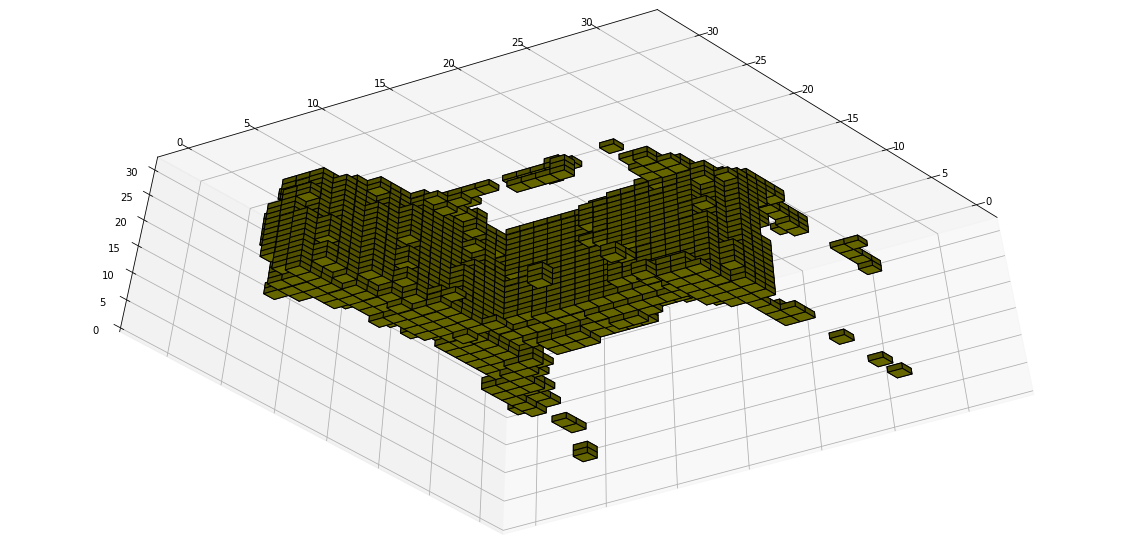

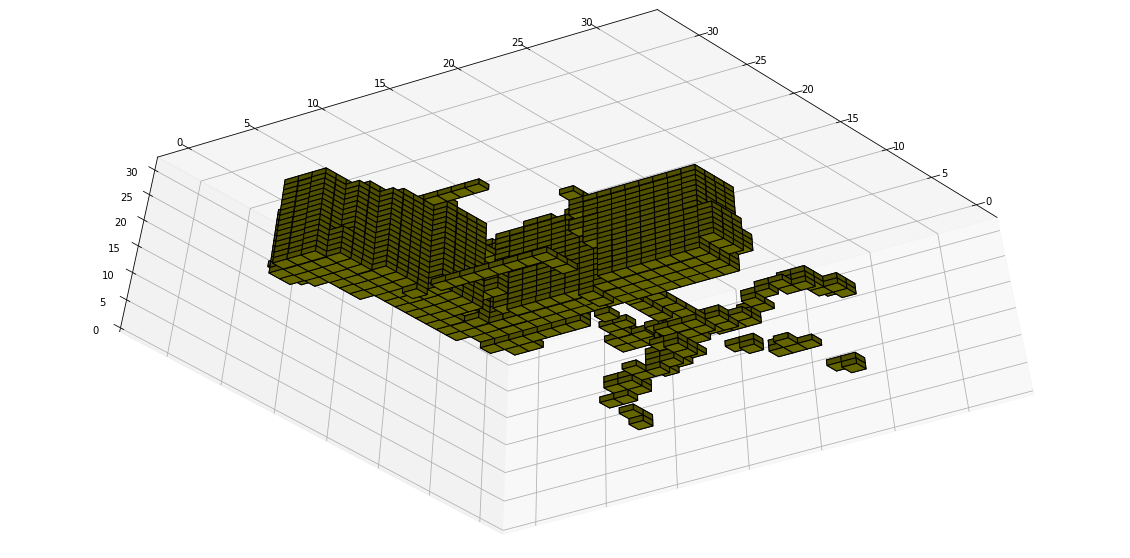

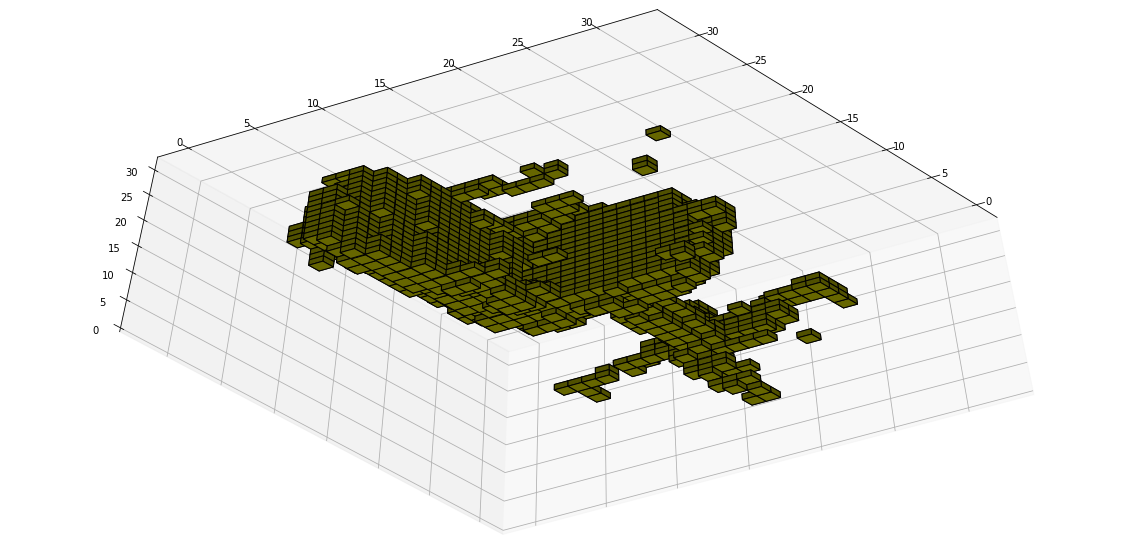

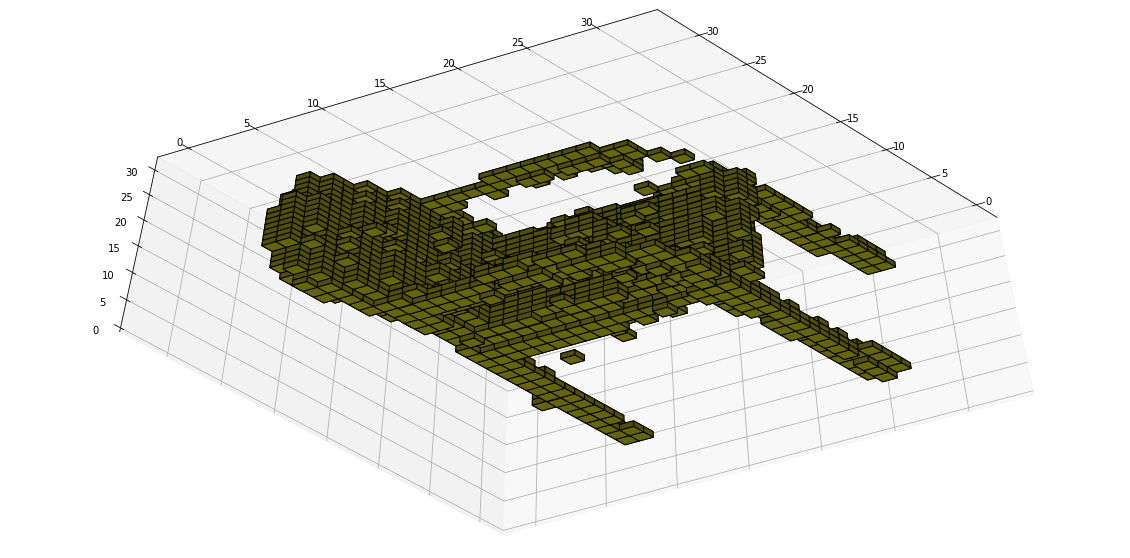

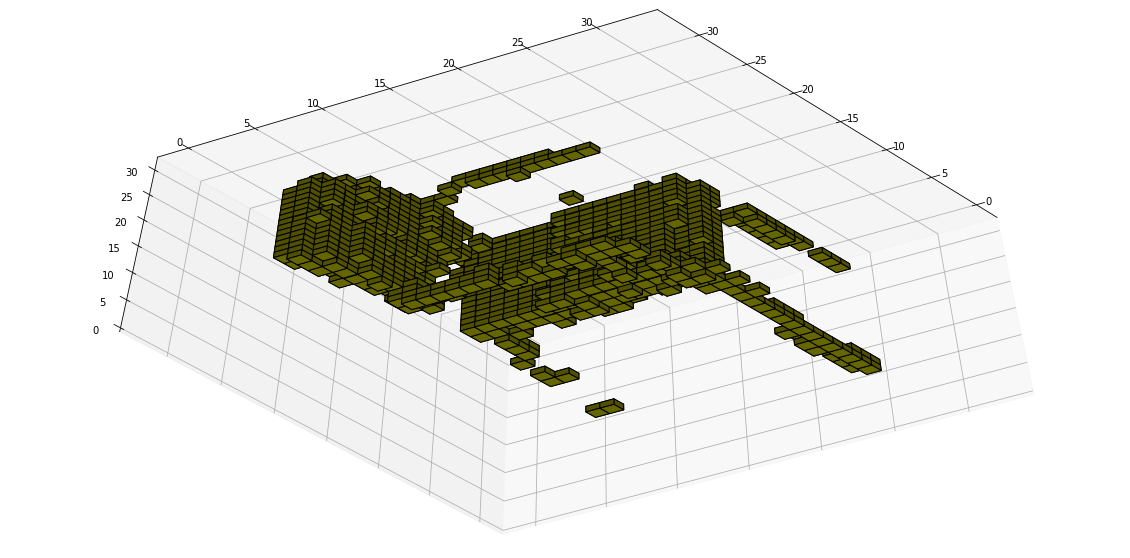

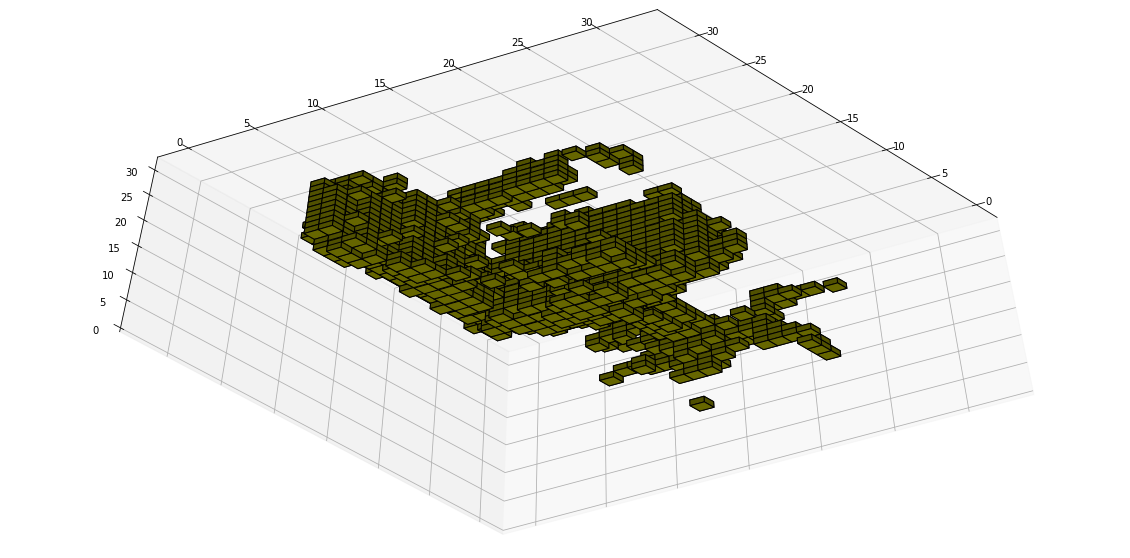

In [88]:
# generar_almacenar_n_imagenes_2_modelos(chair_data_loader, 3, modeloVAE, modeloVAEGAN)

# Probando la reconstrucción por partes

#### Reconstrucción aleatoria de silla completa

In [ ]:
z_dim = 25

modelo = resnet18VAE2(z_dim=z_dim)
model_path = 'modelos/part_chair_vaegan_G_run_28_cuda.pth'

def aTensor(chair):
    return torch.Tensor(chair)
trf_composed = transforms.Compose([aTensor])

modelo = torch.load(model_path, map_location=lambda storage, loc:storage)
#modelo = modelo.to(device)
modelo.eval()

In [ ]:
import copy

# Guardo 15 reconstrucciones aleatorias de el modelo
!mkdir reconRandomVaegan6

# Declaro la fig afuera porque solo voy a usar una y reescribirla muchas veces, para que no se sobrerecargue la RAM
fig = plt.figure(figsize=(20, 10))

for i in range(16):
  # Armo un muestreo de las partes del latent code(100 elementos) para probar qué sale (25 por cada parte de la silla)
  zdim = torch.randn([100])
  z = zdim#.to(device)

  with torch.no_grad():
    reconst = modelo.decoder(z)
    reconst = reconst.numpy()[0, 0, ...]

    # Normalizo, nombro y guardo la imagen completa
    reconst = (reconst - reconst.min()) / (reconst.max() - reconst.min())
    reconst = normalizar(reconst, 0.5)
    
    rutaGuardadoRecon = f"reconRandomVaegan6/{i}_recon_vaegan"

    axes = fig.gca(projection='3d')
    axes.voxels(reconst, facecolors='y', edgecolors='k')
    axes = girar_grafico_3D_frente(axes)
    plt.savefig(rutaGuardadoRecon, format='png')
    fig.clear()
    #plt.close(fig)



    # Sin parte 1
    z1 = copy.deepcopy(z)
    z1[:25] = 0
    
    with torch.no_grad():
      reconst = modelo.decoder(z1)
      reconst = reconst.to('cpu').numpy()[0, 0, ...]

    reconst = (reconst - reconst.min()) / (reconst.max() - reconst.min())
    reconst = normalizar(reconst, 0.5)
    
    rutaGuardadoRecon = f"reconRandomVaegan6/{i}_recon_vaegan_sinParte_1"

    axes = fig.gca(projection='3d')
    axes.voxels(reconst, facecolors='y', edgecolors='k')
    axes = girar_grafico_3D_frente(axes)
    plt.savefig(rutaGuardadoRecon, format='png')
    fig.clear()



    # Sin parte 2
    z2 = copy.deepcopy(z)
    z2[25:50] = 0
    
    with torch.no_grad():
      reconst = modelo.decoder(z2)
      reconst = reconst.to('cpu').numpy()[0, 0, ...]
    
    reconst = (reconst - reconst.min()) / (reconst.max() - reconst.min())
    reconst = normalizar(reconst, 0.5)
    
    rutaGuardadoRecon = f"reconRandomVaegan6/{i}_recon_vaegan_sinParte_2"

    axes = fig.gca(projection='3d')
    axes.voxels(reconst, facecolors='y', edgecolors='k')
    axes = girar_grafico_3D_frente(axes)
    plt.savefig(rutaGuardadoRecon, format='png')
    fig.clear()



    # Sin parte 3
    z3 = copy.deepcopy(z)
    z3[50:75] = 0
    
    with torch.no_grad():
      reconst = modelo.decoder(z3)
      reconst = reconst.to('cpu').numpy()[0, 0, ...]
    
    reconst = (reconst - reconst.min()) / (reconst.max() - reconst.min())
    reconst = normalizar(reconst, 0.5)

    rutaGuardadoRecon = f"reconRandomVaegan6/{i}_recon_vaegan_sinParte_3"

    axes = fig.gca(projection='3d')
    axes.voxels(reconst, facecolors='y', edgecolors='k')
    axes = girar_grafico_3D_frente(axes)
    plt.savefig(rutaGuardadoRecon, format='png')
    fig.clear()



    # Sin parte 4
    z4 = copy.deepcopy(z)
    z4[75:100] = 0
    
    with torch.no_grad():
      reconst = modelo.decoder(z4)
      reconst = reconst.to('cpu').numpy()[0, 0, ...]

    reconst = (reconst - reconst.min()) / (reconst.max() - reconst.min())
    reconst = normalizar(reconst, 0.5)
    
    rutaGuardadoRecon = f"reconRandomVaegan6/{i}_recon_vaegan_sinParte_4"

    axes = fig.gca(projection='3d')
    axes.voxels(reconst, facecolors='y', edgecolors='k')
    axes = girar_grafico_3D_frente(axes)
    plt.savefig(rutaGuardadoRecon, format='png')
    fig.clear()

!cp -r reconRandomVaegan6/. "drive/My Drive/sillas/randomRecon/VAEGAN_2"